# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# from pyfinance.ols import PandasRollingOLS
# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load KOSPI equity OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [4]:
DATA_STORE = '../data/assets.h5'

In [5]:
YEAR = 12

In [6]:
START = 1995
END = 2017

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['finance_datareader/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['kospi/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [8]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2969729 entries, ('000020', Timestamp('1995-05-02 00:00:00')) to ('900140', Timestamp('2017-12-28 00:00:00'))
Data columns (total 9 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   close   2969729 non-null  float64
 1   ratio   2969729 non-null  float64
 2   high    2969729 non-null  float64
 3   low     2969729 non-null  float64
 4   open    2969729 non-null  float64
 5   volume  2969729 non-null  float64
 6   stocks  2969729 non-null  float64
 7   marcap  2969729 non-null  float64
 8   sector  2969729 non-null  object 
dtypes: float64(8), object(1)
memory usage: 215.6+ MB


In [9]:
len(prices.index.unique('ticker'))

694

## Remove stocks with less than ten years of data

In [10]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [11]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2771533 entries, ('000020', Timestamp('1995-05-02 00:00:00')) to ('097950', Timestamp('2017-12-28 00:00:00'))
Data columns (total 9 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   close   2771533 non-null  float64
 1   ratio   2771533 non-null  float64
 2   high    2771533 non-null  float64
 3   low     2771533 non-null  float64
 4   open    2771533 non-null  float64
 5   volume  2771533 non-null  float64
 6   stocks  2771533 non-null  float64
 7   marcap  2771533 non-null  float64
 8   sector  2771533 non-null  object 
dtypes: float64(8), object(1)
memory usage: 201.2+ MB


In [12]:
len(prices.index.unique('ticker'))

536

## Add some Basic Factors

### Compute the Relative Strength Index

In [13]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

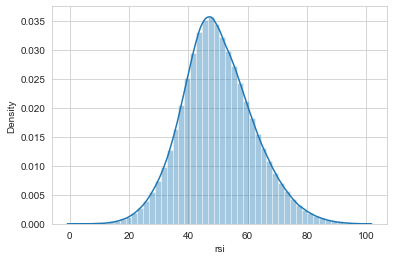

In [14]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [15]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [16]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [17]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2771533 entries, ('000020', Timestamp('1995-05-02 00:00:00')) to ('097950', Timestamp('2017-12-28 00:00:00'))
Data columns (total 13 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   close    2771533 non-null  float64
 1   ratio    2771533 non-null  float64
 2   high     2771533 non-null  float64
 3   low      2771533 non-null  float64
 4   open     2771533 non-null  float64
 5   volume   2771533 non-null  float64
 6   stocks   2771533 non-null  float64
 7   marcap   2771533 non-null  float64
 8   sector   2771533 non-null  object 
 9   rsi      2764029 non-null  float64
 10  bb_high  2761349 non-null  float64
 11  bb_mid   2761349 non-null  float64
 12  bb_low   2761349 non-null  float64
dtypes: float64(12), object(1)
memory usage: 350.3+ MB


In [18]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,2.761349e+06,2.761349e+06,2.761349e+06
mean,9.045200e+00,8.943885e+00,8.842569e+00
std,1.755143e+00,1.758916e+00,1.766500e+00
min,3.853499e+00,3.743741e+00,3.295505e+00
25%,7.758236e+00,7.653894e+00,7.549799e+00
50%,8.890705e+00,8.786144e+00,8.687171e+00
75%,1.016135e+01,1.006317e+01,9.966136e+00
max,2.119279e+01,2.096031e+01,2.082590e+01


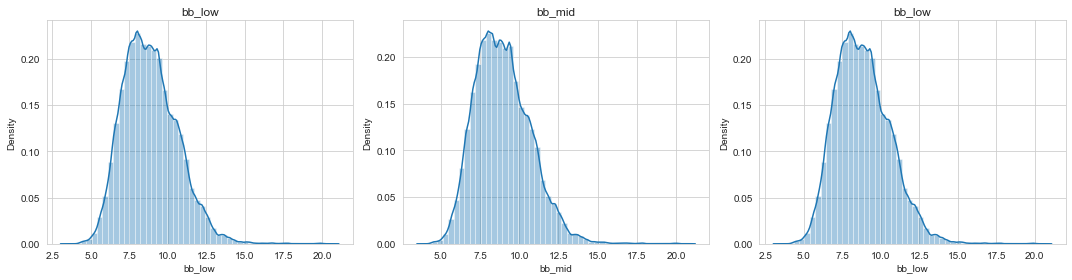

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [20]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

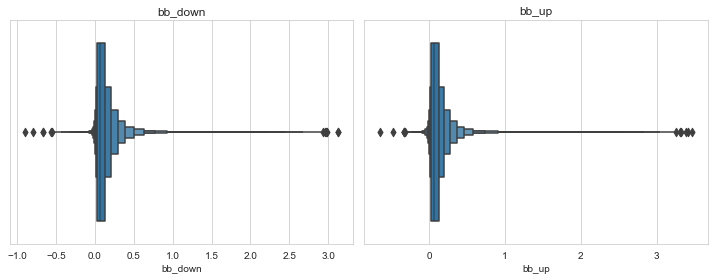

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [22]:
by_ticker = prices.groupby('ticker', group_keys=False)

In [23]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [24]:
prices['atr'] = by_ticker.apply(compute_atr)

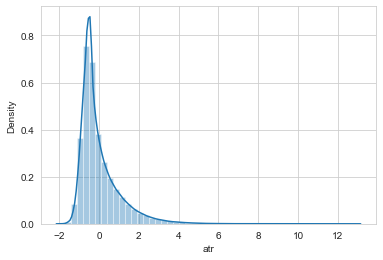

In [25]:
sns.distplot(prices.atr);

In [26]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

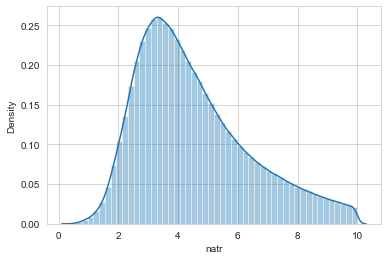

In [27]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [28]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd)

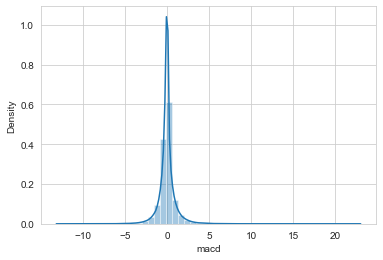

In [29]:
sns.distplot(prices.macd);

## Compute dollar volume to determine universe

In [30]:
prices['dollar_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.dollar_volume /= 1e6

In [31]:
prices.to_hdf('data.h5', 'kr/equities/prices')

In [32]:
prices = pd.read_hdf('data.h5', 'kr/equities/prices')
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2771533 entries, ('000020', Timestamp('1995-05-02 00:00:00')) to ('097950', Timestamp('2017-12-28 00:00:00'))
Data columns (total 19 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   close          2771533 non-null  float64
 1   ratio          2771533 non-null  float64
 2   high           2771533 non-null  float64
 3   low            2771533 non-null  float64
 4   open           2771533 non-null  float64
 5   volume         2771533 non-null  float64
 6   stocks         2771533 non-null  float64
 7   marcap         2771533 non-null  float64
 8   sector         2771533 non-null  object 
 9   rsi            2764029 non-null  float64
 10  bb_high        2761349 non-null  float64
 11  bb_mid         2761349 non-null  float64
 12  bb_low         2761349 non-null  float64
 13  bb_up          2761349 non-null  float64
 14  bb_down        2761349 non-null  float64
 15  atr            27640

## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [33]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                              'open', 'high', 'low']]

In [34]:
prices = prices.unstack('ticker')

In [35]:
data = (pd.concat([prices.dollar_volume.resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 131919 entries, ('000020', Timestamp('1995-06-30 00:00:00')) to ('097950', Timestamp('2017-12-31 00:00:00'))
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   dollar_volume  131919 non-null  float64
 1   atr            131919 non-null  float64
 2   bb_down        131919 non-null  float64
 3   bb_high        131919 non-null  float64
 4   bb_low         131919 non-null  float64
 5   bb_mid         131919 non-null  float64
 6   bb_up          131919 non-null  float64
 7   close          131919 non-null  float64
 8   macd           131919 non-null  float64
 9   marcap         131919 non-null  float64
 10  natr           131919 non-null  float64
 11  ratio          131919 non-null  float64
 12  rsi            131919 non-null  float64
 13  sector         131919 non-null  object 
 14  stocks         131919 non-null  float64
dtypes: float64(14), object(1)
memory usage

## Select 500 most-traded equities

Select the 500 most-traded stocks based on a 5-year rolling average of dollar volume.

In [37]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume']
                         .unstack('ticker')
                         .rolling(window=5*12, min_periods=12)
                         .mean()
                         .stack()
                         .swaplevel())

In [38]:
data['dollar_vol_rank'] = (data
                           .groupby('date')
                           .dollar_volume
                           .rank(ascending=False))

data = data[data.dollar_vol_rank < 500].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

In [39]:
len(data.index.unique('ticker'))

536

## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [40]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [41]:
for lag in lags:
    returns.append(data
                   .close
                   .unstack('ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 125833 entries, ('000020', Timestamp('1996-06-30 00:00:00')) to ('097950', Timestamp('2017-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   125833 non-null  float64
 1   return_3m   124761 non-null  float64
 2   return_6m   123153 non-null  float64
 3   return_12m  119937 non-null  float64
dtypes: float64(4)
memory usage: 4.3+ MB


In [42]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,125833.000000,124761.000000,123153.000000,119937.000000
mean,0.011809,0.005134,0.003382,0.002581
std,0.151533,0.086653,0.062401,0.044279
min,-0.363728,-0.236043,-0.170851,-0.127631
25%,-0.069307,-0.040680,-0.029367,-0.020362
50%,0.000000,0.000000,0.000000,0.000632
75%,0.072937,0.045693,0.033628,0.026036
max,0.615734,0.303630,0.202957,0.129621


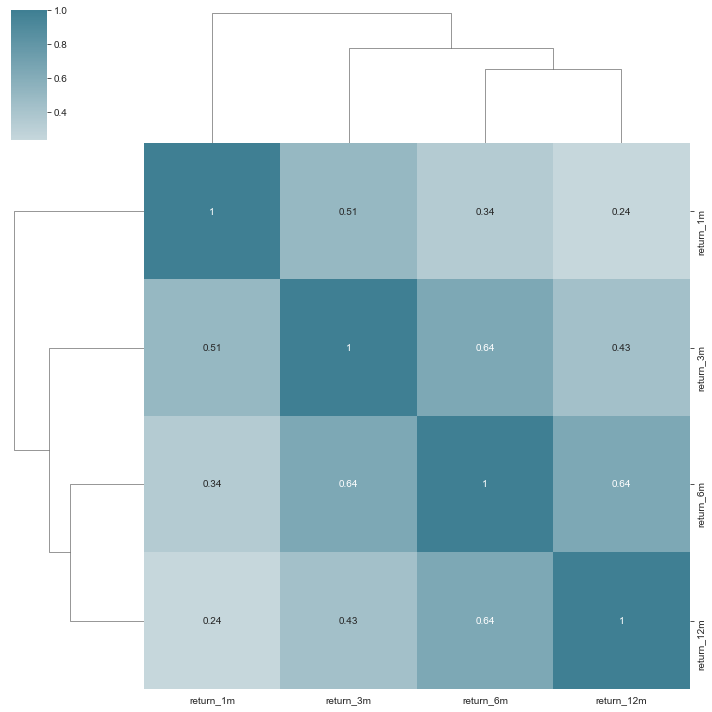

In [43]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [44]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 115230 entries, ('000020', Timestamp('1997-05-31 00:00:00')) to ('097950', Timestamp('2017-12-31 00:00:00'))
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   atr         115230 non-null  float64
 1   bb_down     115230 non-null  float64
 2   bb_high     115230 non-null  float64
 3   bb_low      115230 non-null  float64
 4   bb_mid      115230 non-null  float64
 5   bb_up       115230 non-null  float64
 6   macd        115230 non-null  float64
 7   marcap      115230 non-null  float64
 8   natr        115230 non-null  float64
 9   ratio       115230 non-null  float64
 10  rsi         115230 non-null  float64
 11  sector      115230 non-null  object 
 12  stocks      115230 non-null  float64
 13  return_1m   115230 non-null  float64
 14  return_3m   115230 non-null  float64
 15  return_6m   115230 non-null  float64
 16  return_12m  115230 non-null  float64
dtypes: fl

In [45]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [46]:
len(data.index.unique('ticker'))

534

We are left with 613 tickers.

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [47]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = pd.read_hdf('../data/assets.h5', 'fama_french/equal_weight/korea')
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 299 entries, 1996-07-31 to 2021-05-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  299 non-null    float64
 1   SMB     299 non-null    float64
 2   HML     299 non-null    float64
 3   RMW     299 non-null    float64
 4   CMA     299 non-null    float64
dtypes: float64(5)
memory usage: 14.0 KB


In [48]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 115185 entries, ('000020', Timestamp('1997-05-31 00:00:00', freq='M')) to ('097950', Timestamp('2017-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     115185 non-null  float64
 1   SMB        115185 non-null  float64
 2   HML        115185 non-null  float64
 3   RMW        115185 non-null  float64
 4   CMA        115185 non-null  float64
 5   return_1m  115185 non-null  float64
dtypes: float64(6)
memory usage: 5.7+ MB


In [49]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,115185.000000,115185.000000,115185.000000,115185.000000,115185.000000,115185.000000
mean,0.009971,0.009596,0.010230,0.000170,-0.006957,0.002237
std,0.052801,0.029944,0.043788,0.030750,0.033209,0.135131
min,-0.215948,-0.073927,-0.268538,-0.126366,-0.321206,-0.653064
25%,-0.018963,-0.008903,-0.008865,-0.017502,-0.021860,-0.072362
50%,0.008692,0.010612,0.008676,0.001387,-0.004605,-0.012517
75%,0.033841,0.028448,0.031763,0.019517,0.014708,0.055879
max,0.289336,0.141493,0.236571,0.131968,0.133678,0.762370


In [50]:
T = 60
# betas = (factor_data
#          .groupby(level='ticker', group_keys=False)
#          .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), 
#                                            y=x.return_1m, 
#                                            x=x.drop('return_1m', axis=1)).beta)
#         .rename(columns={'Mkt-RF': 'beta'}))
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .rename(columns={'Mkt-RF': 'beta'})
                .drop('const', axis=1)))

In [51]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,83679.000000,83679.000000,83679.000000,83679.000000,83679.000000,115185.000000
mean,0.419716,-0.032899,0.018525,0.011880,0.031428,0.325933
std,0.583303,0.985757,0.780957,0.801675,0.805190,1.388854
min,-2.155025,-4.034861,-5.462561,-3.585625,-4.263550,-10.673685
25%,0.032414,-0.682516,-0.384408,-0.459988,-0.441124,-0.116779
50%,0.411959,-0.035801,0.091439,0.029979,0.047425,0.000000
75%,0.796269,0.605089,0.511239,0.507972,0.533525,1.083344
max,2.849943,4.181155,3.233261,3.893948,4.059960,7.346156


In [52]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,83679.000000,83679.000000,83679.000000,83679.000000,83679.000000,115185.000000
mean,0.419716,-0.032899,0.018525,0.011880,0.031428,0.325933
std,0.583303,0.985757,0.780957,0.801675,0.805190,1.388854
min,-2.155025,-4.034861,-5.462561,-3.585625,-4.263550,-10.673685
25%,0.032414,-0.682516,-0.384408,-0.459988,-0.441124,-0.116779
50%,0.411959,-0.035801,0.091439,0.029979,0.047425,0.000000
75%,0.796269,0.605089,0.511239,0.507972,0.533525,1.083344
max,2.849943,4.181155,3.233261,3.893948,4.059960,7.346156


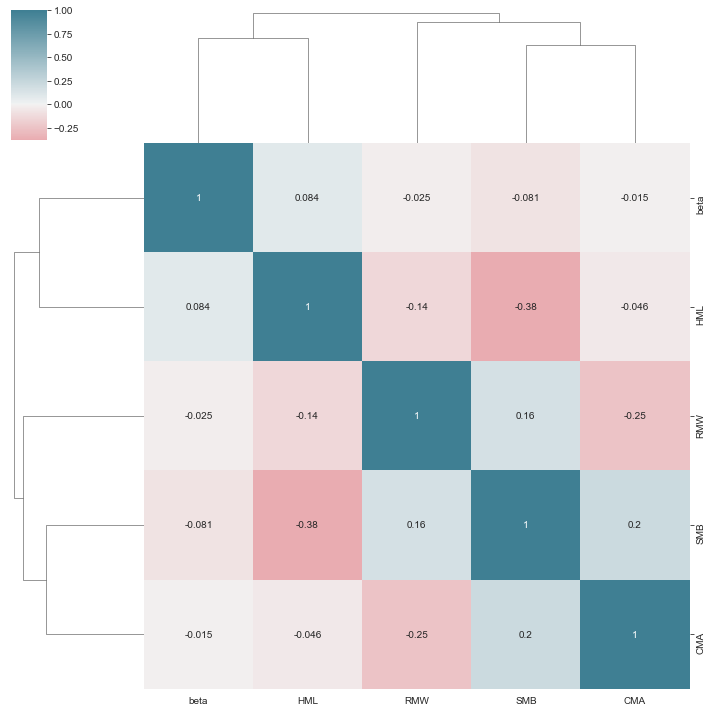

In [53]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [54]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift())
       .dropna()
       .sort_index())

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 83145 entries, ('000020', Timestamp('2002-05-31 00:00:00')) to ('097950', Timestamp('2017-12-31 00:00:00'))
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atr         83145 non-null  float64
 1   bb_down     83145 non-null  float64
 2   bb_high     83145 non-null  float64
 3   bb_low      83145 non-null  float64
 4   bb_mid      83145 non-null  float64
 5   bb_up       83145 non-null  float64
 6   macd        83145 non-null  float64
 7   marcap      83145 non-null  float64
 8   natr        83145 non-null  float64
 9   ratio       83145 non-null  float64
 10  rsi         83145 non-null  float64
 11  sector      83145 non-null  object 
 12  stocks      83145 non-null  float64
 13  return_1m   83145 non-null  float64
 14  return_3m   83145 non-null  float64
 15  return_6m   83145 non-null  float64
 16  return_12m  83145 non-null  float64
 17  beta        83145 non-nul

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [56]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [57]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [58]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)

In [59]:
data = data.dropna()

In [60]:
data.sort_index().info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 82611 entries, ('000020', Timestamp('2002-05-31 00:00:00')) to ('097950', Timestamp('2017-11-30 00:00:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            82611 non-null  float64
 1   bb_down        82611 non-null  float64
 2   bb_high        82611 non-null  float64
 3   bb_low         82611 non-null  float64
 4   bb_mid         82611 non-null  float64
 5   bb_up          82611 non-null  float64
 6   macd           82611 non-null  float64
 7   marcap         82611 non-null  float64
 8   natr           82611 non-null  float64
 9   ratio          82611 non-null  float64
 10  rsi            82611 non-null  float64
 11  sector         82611 non-null  object 
 12  stocks         82611 non-null  float64
 13  return_1m      82611 non-null  float64
 14  return_3m      82611 non-null  float64
 15  return_6m      82611 non-null  float64
 16  return_12m  

## Sector Breakdown

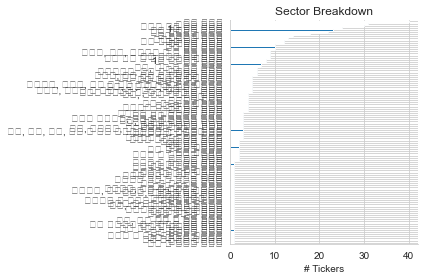

In [61]:
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

## Store data

In [73]:
with pd.HDFStore('data.h5') as store:
    store.put('kr/equities/monthly', data)

## Evaluate mutual information

In [63]:
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]

In [64]:
mi = mutual_info_regression(X=X, y=data.target)

In [65]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

natr          0.060269
ratio         0.045597
return_1m     0.035999
return_6m     0.034380
return_3m     0.032124
return_12m    0.030540
year          0.028125
bb_down       0.025721
momentum_3    0.021604
bb_high       0.021102
dtype: float64

In [66]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [67]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

month            0.008077
atr              0.003287
year             0.002756
ratio            0.002747
momentum_3_12    0.002454
rsi              0.001943
return_6m        0.001866
momentum_12      0.001738
natr             0.001658
stocks           0.001551
dtype: float64

In [68]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [69]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

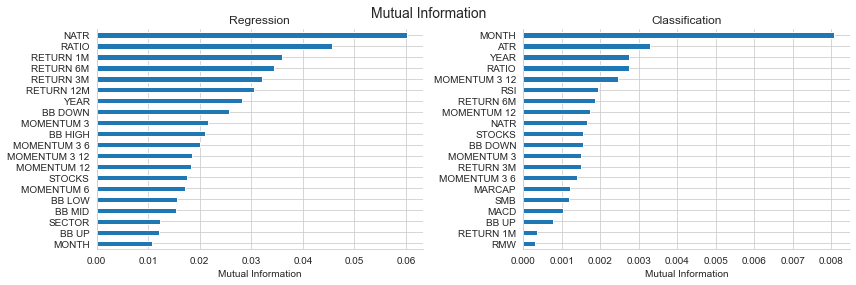

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)